## students Performance Data
- Data source : kaggle
- Date of wright : 2025-04-09
- Purpose of regression : Predicting student's average score with their parental level of education

In [84]:
import importlib
import utils.utils_group

importlib.reload(utils.utils_group)  # 모듈을 강제로 다시 불러옴

# 그 다음 다시 확인
print(dir(utils.utils_group))

['GridSearchCV', 'KFold', 'LGBMRegressor', 'Lasso', 'LinearRegression', 'RandomForestRegressor', 'Ridge', 'StratifiedGroupKFold', 'XGBRegressor', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'cross_val_score', 'feature_importance_check', 'make_scorer', 'mean_absolute_error', 'mean_squared_error', 'missingno', 'np', 'os', 'pd', 'pearsonr', 'pickle', 'plt', 'rmse_scorer', 'sns', 'split_data']


In [85]:
import os
import pickle
import numpy as np
import pandas as pd
import missingno #결측치
import seaborn as sns
import matplotlib.pyplot as plt

# ML model
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#예측 검증 지표
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import KFold

#cross_validation
from sklearn.model_selection import GridSearchCV

from utils.utils_group import split_data, feature_importance_check, rmse_scorer

import warnings

warnings.filterwarnings('ignore')

In [69]:
file_path = 'StudentsPerformance.csv'
# # 데이터 불러오기
df_basic = pd.read_csv(file_path, encoding="cp949")

### 1. EDA
1. Describtion & null 
2. Select feature for encoding

In [70]:
df_basic.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

In [71]:
# df_basic.info()
# missingno.matrix(df_basic) # there is no null value
# df_basic.describe() # Three columns are not continuous columns
df_basic['test preparation course'].value_counts()

test preparation course
none         642
completed    358
Name: count, dtype: int64

In [72]:
# mapping_gender, lunch, perp 
gender = {'male' : 0, 'female' : 1}
lunch = {'standard' : 1, 'free/reduced' : 0 }
prep = {'none' : 0, 'completed' : 1 }
# one tho encoding
parental_education_keys = ["some high school", "high school", "some college", "associate's degree", "bachelor's degree", "master's degree"]
parental_education_values = [i for i in range (1,7)]

parental_deucation_dict = dict(zip(parental_education_keys, parental_education_values))

In [73]:
# copy dataframe
df_clean = df_basic.copy()

# mapping
df_clean['gender'] = df_clean['gender'].map(gender)
df_clean['lunch'] = df_clean['lunch'].map(lunch)
df_clean['test preparation course'] = df_clean['test preparation course'].map(prep)
df_clean['parental level of education'] = df_clean['parental level of education'].map(parental_deucation_dict)

In [74]:
race = list(df_clean['race/ethnicity'].unique())

#df_onehot = 
one_hot= pd.get_dummies(df_clean['race/ethnicity'], prefix='race').astype(int)
df_encoded = pd.concat([df_clean, one_hot], axis=1)
df_encoded.drop(columns=['race/ethnicity'], inplace=True)

In [75]:
# 예측할 값 : 3개 과복 평균 값
df_encoded['score_average'] = df_encoded[['math score', 'reading score', 'writing score']].mean(axis=1).round(1)
df_encoded

,gender,parental level of education,lunch,test preparation course,math score,reading score,writing score,race_group A,race_group B,race_group C,race_group D,race_group E,score_average
0,1,5,1,0,72,72,74,0,1,0,0,0,72.7
1,1,3,1,1,69,90,88,0,0,1,0,0,82.3
2,1,6,1,0,90,95,93,0,1,0,0,0,92.7
3,0,4,0,0,47,57,44,1,0,0,0,0,49.3
4,0,3,1,0,76,78,75,0,0,1,0,0,76.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,6,1,1,88,99,95,0,0,0,0,1,94.0
996,0,2,0,0,62,55,55,0,0,1,0,0,57.3
997,1,2,0,1,59,71,65,0,0,1,0,0,65.0
998,1,3,1,1,68,78,77,0,0,0,1,0,74.3


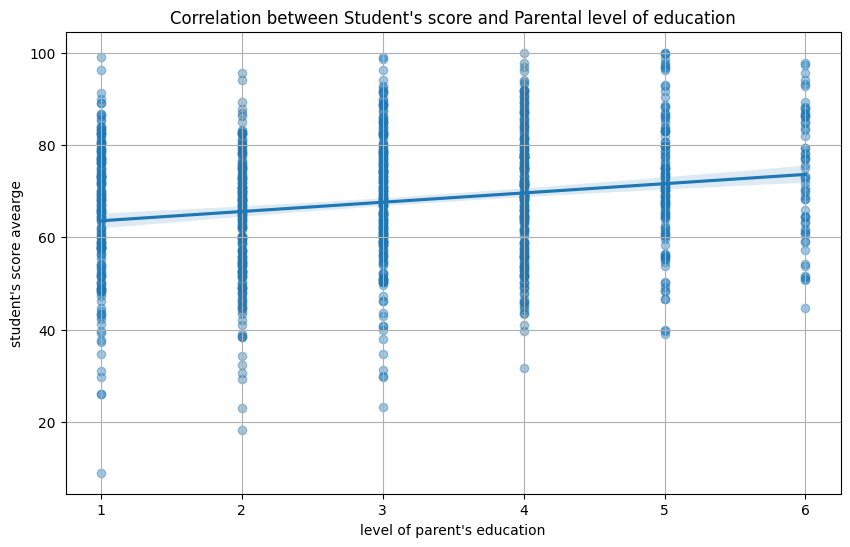

correlation_valuee :0.20582515832735396, p_value : 4.9943968022756715e-11


In [76]:
# correlation between score and parental level of education
corr_value, p_value = pearsonr(df_encoded['parental level of education'], df_encoded['score_average'])

# visualisation
plt.figure(figsize=(10,6))
sns.regplot(data=df_encoded, x='parental level of education', y='score_average',
            scatter_kws={'alpha': 0.4})
plt.title("Correlation between Student's score and Parental level of education")
plt.xlabel("level of parent's education")
plt.ylabel("student's score avearge")
plt.grid(True) #격자 추가

plt.show()
print(f"correlation_valuee :{corr_value}, p_value : {p_value}")


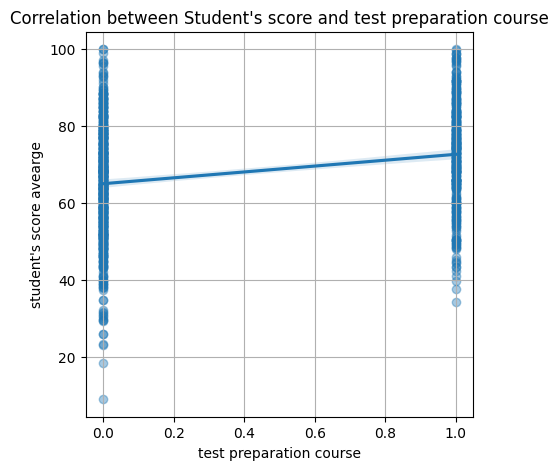

correlation_valuee :0.25676231848753456, p_value : 1.6100509035986067e-16


In [77]:
# correlation between score and parental level of education
corr_value, p_value = pearsonr(df_encoded['test preparation course'], df_encoded['score_average'])

# visualisation
plt.figure(figsize=(5,5))
sns.regplot(data=df_encoded, x='test preparation course', y='score_average',
            scatter_kws={'alpha': 0.4})
plt.title("Correlation between Student's score and test preparation course")
plt.xlabel("test preparation course")
plt.ylabel("student's score avearge")
plt.grid(True) #격자 추가

plt.show()
print(f"correlation_valuee :{corr_value}, p_value : {p_value}")

##### explanation :
- There is weak correlation between student's score and parental level of education
    + Correlation_value is 0.205
        - Normaly, the 0.6 ~ 1.0 score means to have 'strong positive correlationship'

### 2. ML learning
**step1** Split data (for test & train)  
**step2** Fitting several Machin Learning model  
**step3** Feature importance (Decision tree model)  
**step4** Cross_validation  
**step5** Hyper parameter tunning  

##### **step1** Split data (for test & train)

In [78]:
df_train, df_test = split_data(df_encoded)
X_train = df_train.drop(columns=['math score', 'reading score','writing score', 'score_average'], axis=1)
y_train = df_train['score_average']

X_test = df_test.drop(columns=['math score', 'reading score','writing score', 'score_average'], axis=1)
y_test = df_test['score_average']

##### **step2** Fitting several Machin Learning 

In [79]:
# **step2** fit ML
models = {
        "Linear" : LinearRegression(),
        "Ridge" : Ridge(alpha=1.0),
        "Lasso" : Lasso(alpha=0.1),
        "RandomForest_bagging" : RandomForestRegressor(n_estimators=100, random_state=43),
        "XGBoost" : XGBRegressor(n_estimators=100, random_state=43),
        "LGBM" : LGBMRegressor(n_estimators=100, random_state=42, verbose = -1)
        }

results = []

for name, model in models.items():
    # Model Learning
    model.fit(X_train, y_train)
    # predict
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # RMSE 측정
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train)) # train, predict
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test)) # train, predict

    mae_train = mean_absolute_error(y_train,y_pred_train)
    mae_test = mean_absolute_error(y_test,y_pred_test)
    # 오차율 확인

    accuracy_train = ((np.abs((y_pred_train - y_train)/ y_train)) <= 0.05).mean()
    accuracy_test = ((np.abs((y_pred_test - y_test)/ y_test)) <= 0.05).mean()

    # saving result
    results.append((name, rmse_train,rmse_test, mae_train, mae_test, accuracy_train, accuracy_test))

results.sort(key=lambda x: x[2])

results_table = pd.DataFrame(results, columns=['Model', 'RMSE_train','RMSE_test', 'MAE_train', 'MAE_test', 'Accuracy_train', 'Accuracy_test'])

results_table

,Model,RMSE_train,RMSE_test,MAE_train,MAE_test,Accuracy_train,Accuracy_test
0,Linear,12.337290,12.863299,9.941807,10.405876,0.21250,0.200
1,Ridge,12.337343,12.863919,9.940743,10.406519,0.21125,0.195
2,Lasso,12.353262,12.912250,9.944953,10.458329,0.21250,0.195
3,LGBM,11.368430,13.932790,9.066384,11.323302,0.24375,0.160
4,RandomForest_bagging,10.927340,14.543762,8.682072,11.720181,0.25000,0.150
5,XGBoost,10.848715,15.140665,8.498039,12.163467,0.28000,0.145


###### explanation : 
**본 데이터는 Linear 모델 보다는 Decision tree 모델이 더 정밀한 예측이 가능할 것으로 보임**
1. 모델별 검정지표의 격차 : 
    - 다른 모델보다 Decisiontree 모델 (XGBoost & Randomforest) 에서 RMSE & MAE의 오차가 적게 나타남
    - Linear 모델이 Decisiontree (XGBoost & Randomfoest)예측 성능 지표 차이가 큼
        
2. 특이점
    - LightGBM만 다른 Decisiontree 모델 보다 MAE의 격차가 큰것으로 보아 몇개의 큰 오차가 모델에 영향을 미쳤을 것으로 볼 수 있음
---
**<basic_info>**
- MAE (Mean Absolute Error)
    + 오차(실제값 - 예측값) 를 절대값으로 변환하여 평균을 측정한 것으로
    + 오차 크기가 그대로 더해져서 평균을 내기 때문에 큰오차와 작은오차가 동일하게 반영됨
- RMSE (Root Mean Squared Error)
    + 오차를 제곱한 후에 평균내서 제곱근을 측정한 것으로
    + 큰 오차에 더큰 패널티가 부여됨
- 예를 들어, 똑같은 5의 오차더라도 MAE는 5이고 RMSE는 25임으로 RMSE로 측정하면 오차가 큰 값이 더 크게 나타남
    + 즉, MAE & RMSE가 비슷하게 나타난다면 큰 오차가 없이 예측과 실제 값이 비슷하다는 의미

##### **step3** Feature importance (Decision tree model)

In [87]:
Random_feature = feature_importance_check(RandomForestRegressor, X_train, y_train)
XGBR_feature = feature_importance_check(XGBRegressor, X_train, y_train)
Light_feature = feature_importance_check(LGBMRegressor, X_train, y_train)

# combine three tables
# pd.concat([Random_feature, XGBR_feature, Light_feature],
#           axis=1, keys=['Random_feature', 'XGBR_feature', 'Lirght_feature']
# )
print(Random_feature.head(3) , XGBR_feature.head(3), Light_feature.head(3))

                             Importance
feature                                
parental level of education        0.29
test preparation course            0.16
lunch                              0.16                          Importance
feature                            
lunch                          0.16
test preparation course        0.16
race_group A                   0.13                              Importance
feature                                
parental level of education        1007
gender                              386
race_group C                        282


###### explanation :
- 중요도 값은 단순히 각 모델이 데이터의 특성을 어떻게 사용했는지를 보여주는 지표이기 때문에, 실제로는 바로 위에서 추출한 예측 성능(MAE, RMSE)가 더 중요함
    + 같은 Decisiontree 모델도 각기 다른 매커니즘과 중요도 계산 방식을 사용하기 때문에 각자 다른 단위를 가지지 않을 수 있음
    + 값의 크기를 비교하기 보다, 하나의 모델로 계산한 importance값을 가지고 상대적 중요도를 비교하는 것이 유용함

- 위 성과지표도 중요하지만, CV(Cross_validation)을 통한 안전성 평가를 여러번해서 어떤 모델이 꾸준이 좋은 성능을 내는지 확인이 필요함

##### **step4** Cross validation
- 1.2에서 기본 ML을 활용하여 학습한 결과, 기본 ML을 사용할 경우 train 데이터에 과적합되어 있는 것으로 보임
- 때문에 cross-validation 을 진행하여 과적합(overfitting)을 줄이고, 일관된 성능 지표을 얻고자함

In [88]:
scorer = make_scorer(rmse_scorer, greater_is_better=False)

cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv = 5,
                             scoring=scorer)
    cv_results[name] = {"mean_rmse": -scores.mean(), 'std_rmse' : scores.std()}

for name, metrics in cv_results.items():
    print(f"{name}: mean RMSE = {metrics['mean_rmse']:.3f}, std = {metrics['std_rmse']:.3f}")

Linear: mean RMSE = 12.485, std = 0.778
Ridge: mean RMSE = 12.483, std = 0.781
Lasso: mean RMSE = 12.486, std = 0.776
RandomForest_bagging: mean RMSE = 14.310, std = 0.521
XGBoost: mean RMSE = 15.008, std = 0.605
LGBM: mean RMSE = 13.492, std = 0.685


###### explanation : 
- RSME 평균값이 높을 수록, 모델 성능이 좋음 
- 표준편자(standard)가 낮을 수록 성능이 일정하게 유지된다는 것을 의미하고, 
  높다면 fold(분할된 데이터)에 따라 성능이 들쑥 날쑥하고 특정데이터 분할에서만 좋은 성능을 낸다는 것으로 알 수 있음
- 위 결과값은 linear 모델이 RSME와 standard가 낮음으로 간단한 linear 모델이 가장 적합할 것으로 보임
  + Ridge(L2정규화) & Lasso(L1정규화)의 alpha 값을 활용하여 조정할 예정
    - 클수록 더 강한 정규화를 하고자함

#### **step5** Hyper parameter tunning

In [89]:
ridge_params = {'alpha' : [0.1, 1, 10, 100, 1000]}
ridge_grid = GridSearchCV(Ridge(), param_grid=ridge_params, scoring=scorer, cv=5, verbose=1)

ridge_grid.fit(X_train,y_train)

#최적의 하이퍼파라미터
print("Best Ridge params:", ridge_grid.best_params_)
print("Best Ridge RMSE:", -ridge_grid.best_score_)

lasso_params = {'alpha':[0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(Lasso(), param_grid=lasso_params, scoring=scorer, cv=5, verbose=1)

lasso_grid.fit(X_train, y_train)

#최적의 하이퍼파라미터
print("Best lasso params:", lasso_grid.best_params_)
print("Best lasso RMSE:", -lasso_grid.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Ridge params: {'alpha': 10}
Best Ridge RMSE: 12.474956601339956
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best lasso params: {'alpha': 0.01}
Best lasso RMSE: 12.483851458006045


### 3. Final fitting model and check test_data's predict score and accuracy

In [90]:
best_alpha_ridge = ridge_grid.best_params_['alpha']
final_ridge_model = Ridge(alpha = best_alpha_ridge)

final_ridge_model.fit(X_train, y_train)
y_pred_test = final_ridge_model.predict(X_test)

final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
final_rme = mean_absolute_error(y_test, y_pred_test)
final_accuracy = (np.abs((y_pred_test-y_test)/y_test) < 0.05).mean().round(2)

print("final_rmse :", final_rmse,
      "final_rme :", final_rme,
      "final_accuracy :", final_accuracy 
      )

final_rmse : 12.87271890433138 final_rme : 10.415842336410874 final_accuracy : 0.2


In [92]:
## saving model as pickle
import pickle

best_model = ridge_grid.best_estimator_

with open("Student_performance_ridge_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Successfully save the model!")

Successfully save the model!
